In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
from scipy.stats import  kurtosis
from sklearn.decomposition import DictionaryLearning

# Plot customization
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-colorblind')

# Read data and preprocessing

In [2]:
data = pd.read_csv('datasets_311_673_survey.csv')

print("Dataset Shape: ", data.shape)
data.head()

Dataset Shape:  (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
# Timestamps are all unique values
data = data.drop(['Timestamp'], axis= 1)

# Comments are optional free text field.
# There are only 164 comments and may not all related to the dataset
data = data.drop(['comments'], axis= 1)

# There are a lot of missing values in state. 
# This field can be ignore if not take the locations into account.
data = data.drop(['state'], axis= 1)

# Cleaning NaN values

default_int = 0
default_string = 'NaN'
default_float = 0.0

data['Age'].fillna(default_int)

for feature in ['Gender', 'Country', 'family_history', 'treatment',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']:
    data[feature] = data[feature].fillna(default_string)

print("Len(): ", len(data['Gender'].str.lower().unique()))
data['Gender'].str.lower().unique()

male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in data.iterrows():
    if str.lower(col.Gender) in male_str:
        data['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)
    if str.lower(col.Gender) in female_str:
        data['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)
    if str.lower(col.Gender) in trans_str:
        data['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

# Remove outlier that's not useful
stk_list = ['A little about you', 'p']
data = data[~data['Gender'].isin(stk_list)]

print(data['Gender'].unique())

# Remove outlier age

data.drop(data[data['Age'] < 0].index, inplace = True) 
data.drop(data[data['Age'] > 100].index, inplace = True) 

# Add column age_range
data['age_range'] = pd.cut(data['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

print(data['self_employed'].value_counts())
data['self_employed'].fillna('No',inplace=True)

print(data['work_interfere'].value_counts())
data['work_interfere'].fillna('Sometimes',inplace=True)


Len():  43
['female' 'male' 'trans']
No     1092
Yes     143
Name: self_employed, dtype: int64
Sometimes    464
Never        213
Rarely       173
Often        140
Name: work_interfere, dtype: int64


In [4]:
# Drop 'Country' column
data = data.drop(['Country'], axis= 1)

data.isnull().sum()

Age                          0
Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
age_range                    0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

labelDict = {}
for feature in data:
    le = preprocessing.LabelEncoder()
    le.fit(data[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    data[feature] = le.transform(data[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

label_Age [5, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ['Never', 'Often', 'Rarely', 'Sometimes']
label_no_employees ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']
label_remote_work ['No', 'Yes']
label_tech_company ['No', 'Yes']
label_benefits ["Don't know", 'No', 'Yes']
label_care_options ['No', 'Not sure', 'Yes']
label_wellness_program ["Don't know", 'No', 'Yes']
label_seek_help ["Don't know", 'No', 'Yes']
label_anonymity ["Don't know", 'No', 'Yes']
label_leave ["Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', 'Very easy']
label_mental_health_consequence ['Maybe', 'No', 'Yes']
label_phys_health_consequence ['Maybe', 'No', 'Yes']
label_coworkers 

In [6]:
scaler = MinMaxScaler()
data['Age'] = scaler.fit_transform(data[['Age']])
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.456522,0,0,0,1,1,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.608696,1,0,0,0,2,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.347826,1,0,0,0,2,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.326087,1,0,1,1,1,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.326087,1,0,0,0,0,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [7]:
data.columns

Index(['Age', 'Gender', 'self_employed', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from external_fn import plot_learning_curve, plot_validation_curve, plot_roc_auc_curve

x = data[['Age', 'Gender', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range' ]]
y = data['treatment']

# Plot customization
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-colorblind')

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [10]:
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [11]:
result = {
    'k-means': {}, 
    'Expectation_Maximization': {},
    'PCA': {},
    'ICA': {},
    'Randomized_Projections': {},
    'Infomation_Gain': {},
    'experiments': [],
    'Step4_Neural_Network': {},
    'Step5_Neural_Network': {},
}

In [12]:
%%time
task = "k-means"

f1 = []
train_acc = []
test_acc = []
params = [2]

for k in params:
    print("K = ", k)
    clf = KMeans(n_clusters=2)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    result[task][k] = {
        "accuracy_score" : accuracy_score(y_test,y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred),
        "f1" : f1_score(y_test,y_pred, average='binary'),
        "training_acc": clf.score(x_train, y_train),
        "testing_acc": clf.score(x_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, x, y, cv=10, scoring='roc_auc'),
    }
    print("Accuracy: ", result[task][k]["accuracy_score"])
    print("ROC AUC score: ", result[task][k]["roc_auc"])
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    # print("Cross Validation Score")
    # print(result[task][k]["cross_validation_score"])

    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])
    
    # plot_learning_curve(clf, f"{task} (k={k})", x, y, axes=None, cv=10, n_jobs=4)
    # plt.savefig(f'mental_plots/learning_curve_{task}_{k}.png')
    # plt.show()
    
# # Validation Curve
# new_params = params
# plot_validation_curve(KMeans(), f"{task}: n_neighbors", x, y, "n_neighbors", new_params, scoring="accuracy", axes=None, cv=10, n_jobs=4)
# plt.savefig(f'mental_plots/validation_curve_{task}.png')
# plt.show()

K =  2
Accuracy:  0.4581673306772908
ROC AUC score:  0.47014537902388365
F1 Score:  0.45161290322580644
Training Accuracy:  -11941.370281070802
Testing Accuracy:  -2909.548268249253
Confusion Matrix
[[59 48]
 [88 56]]
Classification Report
              precision    recall  f1-score   support

           0       0.40      0.55      0.46       107
           1       0.54      0.39      0.45       144

    accuracy                           0.46       251
   macro avg       0.47      0.47      0.46       251
weighted avg       0.48      0.46      0.46       251

CPU times: user 4.53 s, sys: 3.82 s, total: 8.35 s
Wall time: 1.2 s


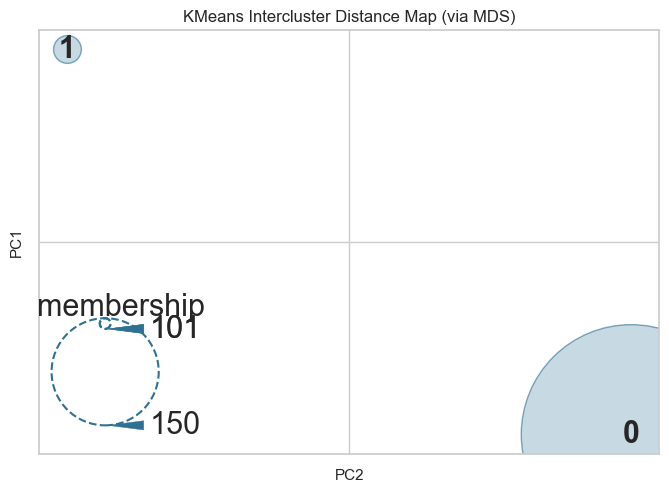

In [13]:
from yellowbrick.cluster import intercluster_distance
from yellowbrick.cluster import silhouette_visualizer

visualizer = intercluster_distance(KMeans(2), x_test)

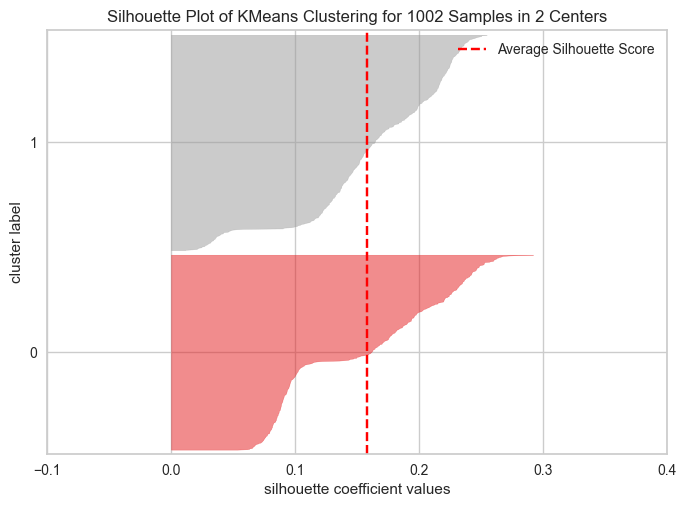

In [14]:
visualizer = silhouette_visualizer(KMeans(2), x_train)

In [15]:
from external_fn import *

In [16]:
scaler = preprocessing.StandardScaler().fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

CPU times: user 9 µs, sys: 27 µs, total: 36 µs
Wall time: 10 µs


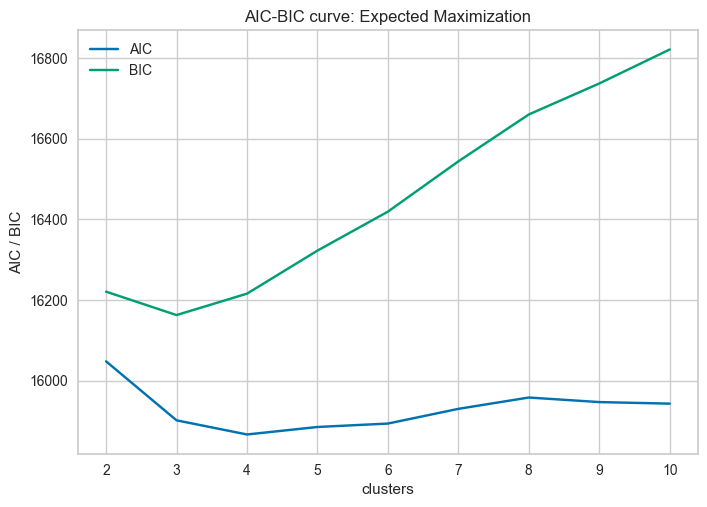

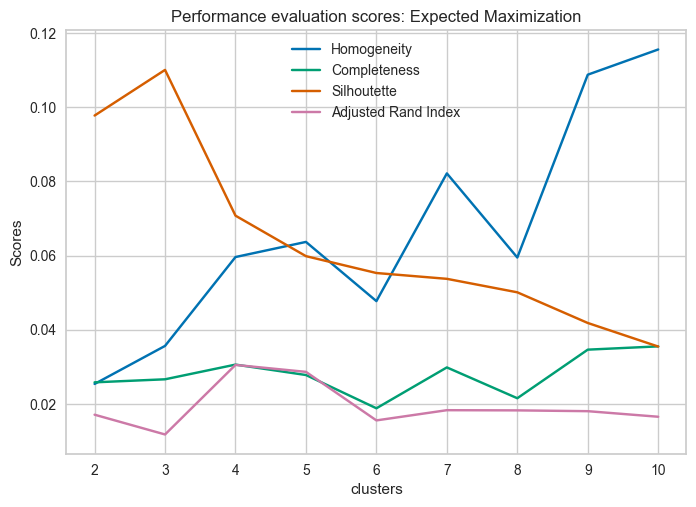

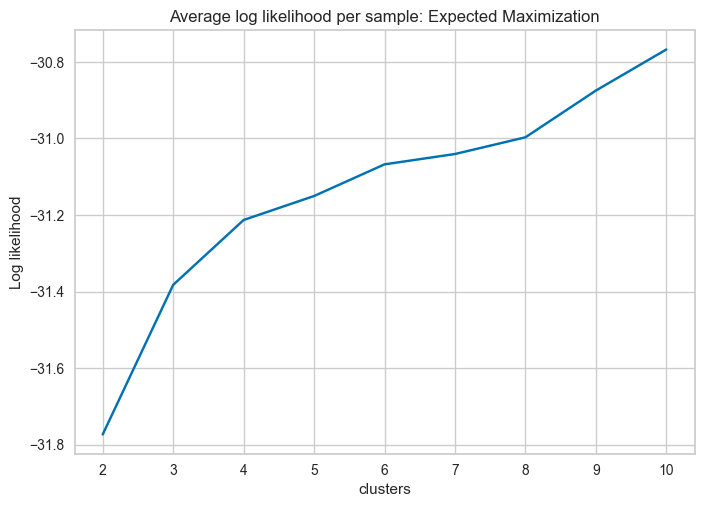

Training accuracy for Expected Maximization for K = 2:  61.77644710578842
Testing accuracy for Expected Maximization for K = 2:  58.964143426294825
accuracy_score 	 0.5896414342629482
roc_auc 	 0.6039395119418484
f1 	 0.5863453815261044
confusion_mat 	 [[75 32]
 [71 73]]
classification_report 	               precision    recall  f1-score   support

           0       0.51      0.70      0.59       107
           1       0.70      0.51      0.59       144

    accuracy                           0.59       251
   macro avg       0.60      0.60      0.59       251
weighted avg       0.62      0.59      0.59       251



In [17]:
%time
num_class = 2
means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(2)])
clf_em = expectation_maximization(X_train, X_test, y_train, y_test, init_means = means_init, component_list = [2,3,4,5,6,7,8,9,10], num_class = 2)

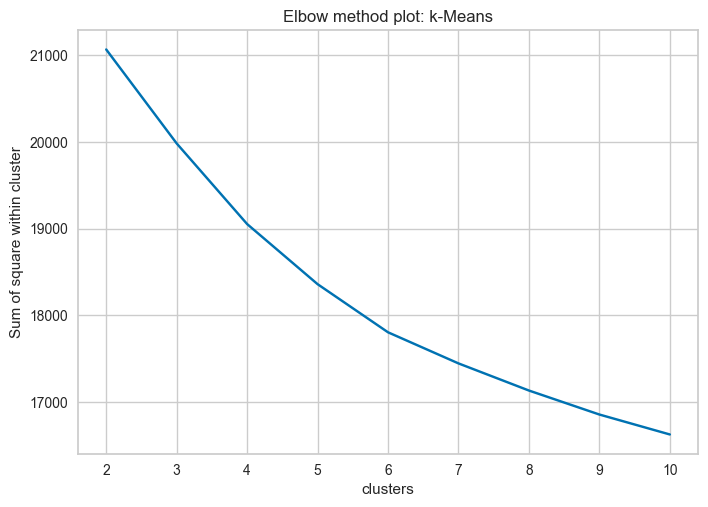

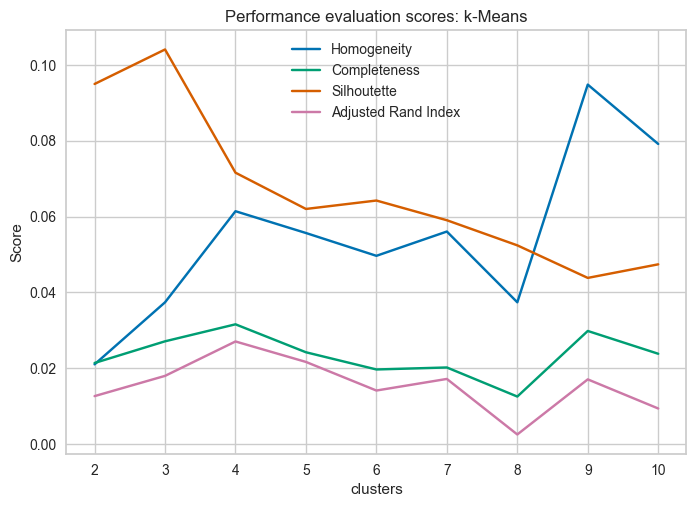

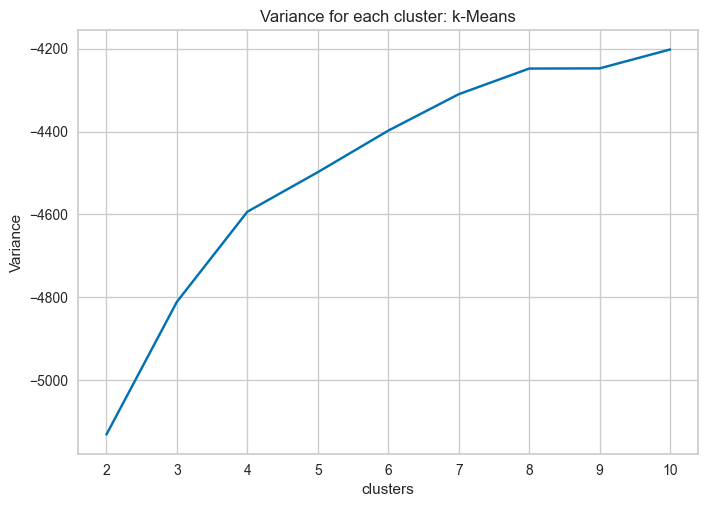

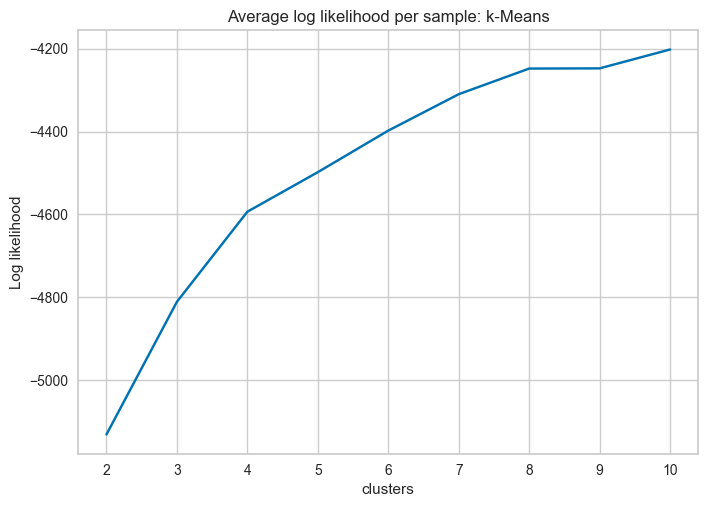

Training accuracy:  k-Means - K = 2:  62.874251497005986
Testing accuracy for  k-Means for K = 2:  56.17529880478087
accuracy_score 	 0.5617529880478087
roc_auc 	 0.577232606438214
f1 	 0.5528455284552845
confusion_mat 	 [[73 34]
 [76 68]]
classification_report 	               precision    recall  f1-score   support

           0       0.49      0.68      0.57       107
           1       0.67      0.47      0.55       144

    accuracy                           0.56       251
   macro avg       0.58      0.58      0.56       251
weighted avg       0.59      0.56      0.56       251



In [18]:
clf_kmeans = kmeans(X_train, X_test, y_train, y_test, init_means = means_init, component_list = [2,3,4,5,6,7,8,9,10], num_class = 2)

# Dimensionality Reduction

## PCA

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def fit_random_forest_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
    # clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    acc = accuracy_score(y_test, y_preds)
    return acc

In [20]:
x=StandardScaler().fit_transform(x)
pca_accs=[]
pca_comps=[]
pca_reconstruction_error=[]
pca_variance_explained_raw=[]
pca_variance_explained=[]
for comp in range(2,24):
    pca=PCA(comp)
    x_pca=pca.fit_transform(x)
    acc=fit_random_forest_classifier(x_pca, y)
    pca_variance_explained_raw.append(pca.explained_variance_ratio_)
    pca_variance_explained.append(np.sum(pca.explained_variance_ratio_))
    pca_comps.append(comp)
    pca_accs.append(acc)
    X_projected = pca.inverse_transform(x_pca)
    pca_reconstruction_error.append(((x - X_projected) ** 2).mean())

In [21]:
pca_variance_explained_raw[-1]

array([0.12070428, 0.09297544, 0.07930631, 0.06656113, 0.05441186,
       0.05233427, 0.0467106 , 0.04560361, 0.04392874, 0.04118817,
       0.03808944, 0.0366461 , 0.03573518, 0.03317301, 0.03169204,
       0.03000477, 0.02920711, 0.02598008, 0.02496737, 0.02248052,
       0.02153498, 0.0175663 , 0.0091987 ])

Text(0.5, 1.0, 'PCA: Reconstruction error')

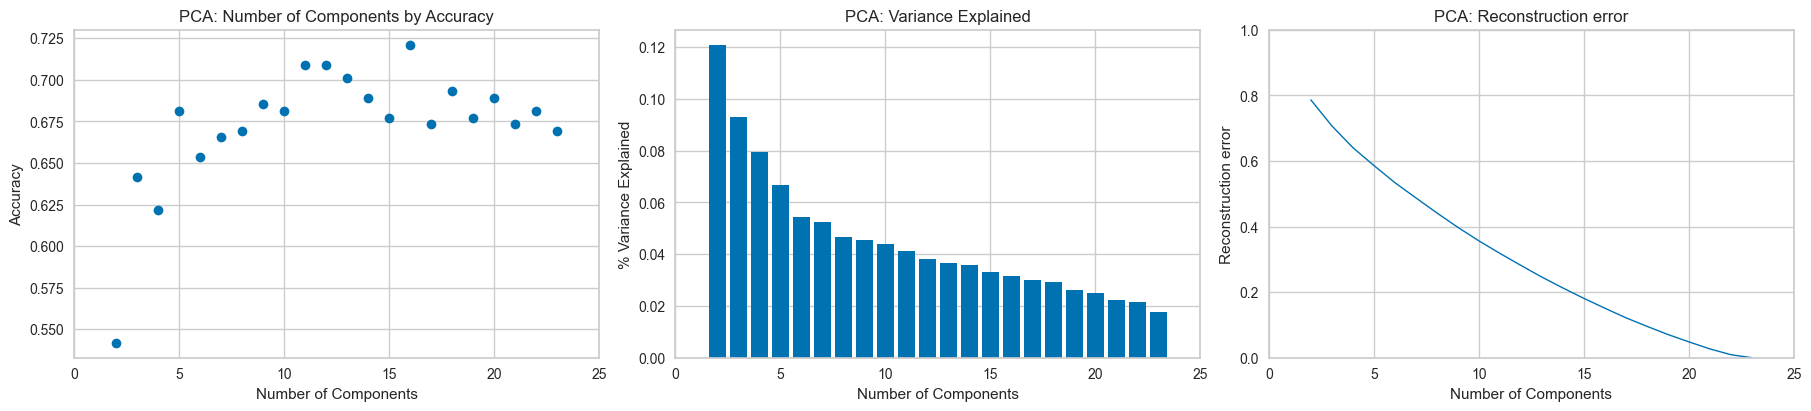

In [22]:
fig, axs = plt.subplots(1 , 3,figsize=(18, 4), constrained_layout=True,)
axs[0].plot(pca_comps,pca_accs,'o')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Components')
axs[0].set_xlim(0,25)
axs[0].set_title('PCA: Number of Components by Accuracy')

axs[1].bar(pca_comps, pca_variance_explained_raw[-1][:-1], linewidth= 1)
axs[1].set_ylabel('% Variance Explained')
axs[1].set_xlabel('Number of Components')
axs[1].set_xlim(0,25)
axs[1].set_title('PCA: Variance Explained')

axs[2].plot(pca_comps, pca_reconstruction_error, linewidth= 1)
axs[2].set_ylabel('Reconstruction error')
axs[2].set_xlabel('Number of Components')
axs[2].set_xlim(0,25)
axs[2].set_ylim(0,1)
axs[2].set_title('PCA: Reconstruction error')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')
# plt.plot(pca_comps,pca_accs,'o')
# plt.ylabel('Accuracy')
# plt.xlabel('Number of Components')
# plt.xlim(0,24)
# plt.title('Number of Components by Accuracy')

# plt.plot(pca_comps, pca_reconstruction_error, linewidth= 1)
# # ax2.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
# plt.xlabel('Number of Components')
# plt.ylabel('Reconstruction Error')
# plt.title('Reconstruction error')
# plt.xlim(0,24)
# plt.show()


In [23]:
# Best PCA
np.max(pca_accs),pca_comps[np.where(pca_accs == np.max(pca_accs))[0][0]]

(0.7211155378486056, 16)

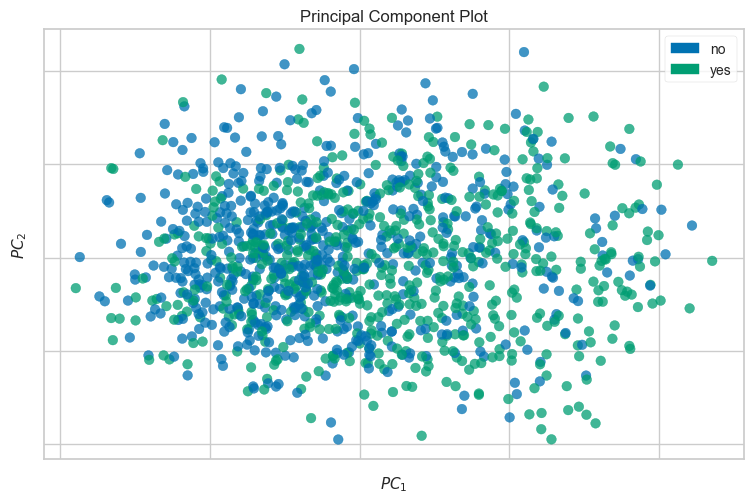

<AxesSubplot: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [24]:
from yellowbrick.features import PCA

classes = ["no", "yes"]
visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(x, y)
visualizer.show()

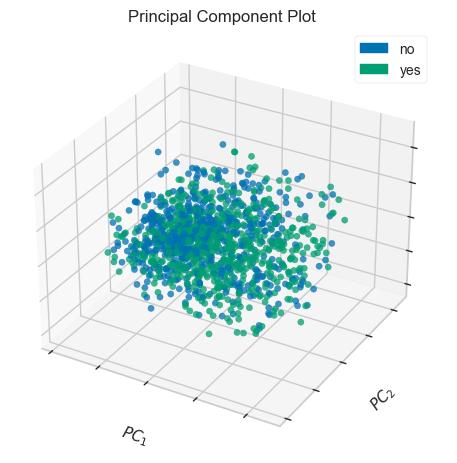

<Axes3DSubplot: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$', zlabel='$PC_3$'>

In [25]:
classes = ["no", "yes"]
visualizer = PCA(scale=True, projection=3, classes=classes)
visualizer.fit_transform(x, y)
visualizer.show()

## ICA

In [26]:
from scipy.stats import kurtosis

ica_accs=[]
ica_comps=[]
ica_reconstruction_error=[]
ica_kurtosis_raw=[]
ica_kurtosis=[]
for comp in range(2,24):
    ica=FastICA(comp)
    x_ica=ica.fit_transform(x)
    acc=fit_random_forest_classifier(x_ica, y)
    ica_kurtosis_raw.append(kurtosis(x_ica))
    ica_kurtosis.append(np.mean(np.abs(kurtosis(x_ica))))
    ica_comps.append(comp)
    ica_accs.append(acc)
    X_projected = ica.inverse_transform(x_ica)
    ica_reconstruction_error.append(((x - X_projected) ** 2).mean())

Text(0.5, 1.0, 'ICA: Reconstruction error')

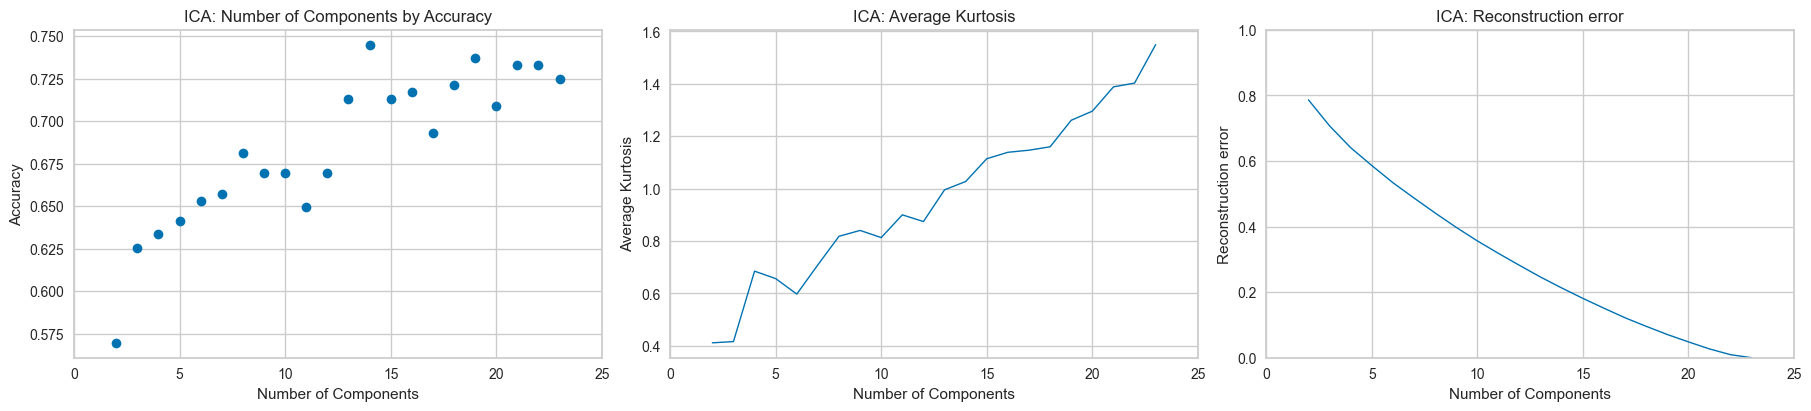

In [27]:
fig, axs = plt.subplots(1 , 3,figsize=(18, 4), constrained_layout=True,)
axs[0].plot(ica_comps,ica_accs,'o')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Components')
axs[0].set_xlim(0,25)
axs[0].set_title('ICA: Number of Components by Accuracy')

axs[1].plot(ica_comps, ica_kurtosis, linewidth= 1)
axs[1].set_ylabel('Average Kurtosis')
axs[1].set_xlabel('Number of Components')
axs[1].set_xlim(0,25)
axs[1].set_title('ICA: Average Kurtosis')

axs[2].plot(ica_comps, ica_reconstruction_error, linewidth= 1)
axs[2].set_ylabel('Reconstruction error')
axs[2].set_xlabel('Number of Components')
axs[2].set_xlim(0,25)
axs[2].set_ylim(0,1)
axs[2].set_title('ICA: Reconstruction error')


In [28]:
# Best ICA
np.max(ica_accs),ica_comps[np.where(ica_accs == np.max(ica_accs))[0][0]]

(0.7450199203187251, 14)

## Randomized Projection

In [29]:
from sklearn.random_projection import SparseRandomProjection

rp_losses=[]
rp_accs = []

for i in range(1,24):
    random_projection = SparseRandomProjection(n_components=i, random_state=42)
    random_projection.fit(x)
    components =  random_projection.components_.toarray()
    p_inverse = np.linalg.pinv(components.T)
    #now get the transformed data using the projection components
    reduced_data = random_projection.transform(x)
    acc=fit_random_forest_classifier(reduced_data, y)
    rp_accs.append(acc)
    reconstructed= reduced_data.dot(p_inverse)
    error = metrics.mean_squared_error(x, reconstructed)
    rp_losses.append(error)
    

Text(0.5, 1.0, 'Randomized Projection: Reconstruction error')

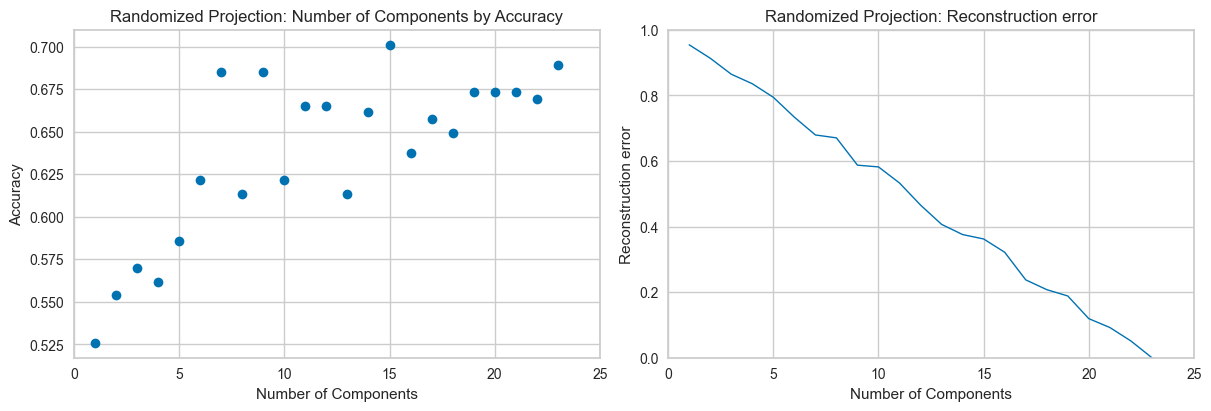

In [30]:
fig, axs = plt.subplots(1 , 2,figsize=(12, 4), constrained_layout=True,)
axs[0].plot(range(1,24),rp_accs,'o')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Components')
axs[0].set_xlim(0,25)
axs[0].set_title('Randomized Projection: Number of Components by Accuracy')

axs[1].plot(range(1,24),rp_losses, linewidth= 1)
axs[1].set_ylabel('Reconstruction error')
axs[1].set_xlabel('Number of Components')
axs[1].set_xlim(0,25)
axs[1].set_ylim(0,1)
axs[1].set_title('Randomized Projection: Reconstruction error')

In [31]:
from sklearn.random_projection import GaussianRandomProjection

def inverse_transform_rp(rp, X_transformed, X_train):

	return X_transformed.dot(rp.components_) + np.mean(X_train, axis = 0)


accs = []
reconstruction_error = []
for i in range(1,24):
	rp = GaussianRandomProjection(n_components = comp)
	X_transformed = rp.fit_transform(x)
	X_projected = inverse_transform_rp(rp, X_transformed, x)
	reconstruction_error.append(((x - X_projected) ** 2).mean())
	accs.append(fit_random_forest_classifier(X_transformed, y))

# fig2,ax2 = plt.subplots()
# ax2.plot(range(1,24), reconstruction_error, linewidth= 2)
# ax2.axvline(gridSearch.best_estimator_.named_steps['rp'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
# plt.axis('tight')
# plt.xlabel('Number of components')
# plt.ylabel('Reconstruction Error')
# plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
# plt.show()

Text(0.5, 1.0, 'Randomized Projection: Reconstruction error')

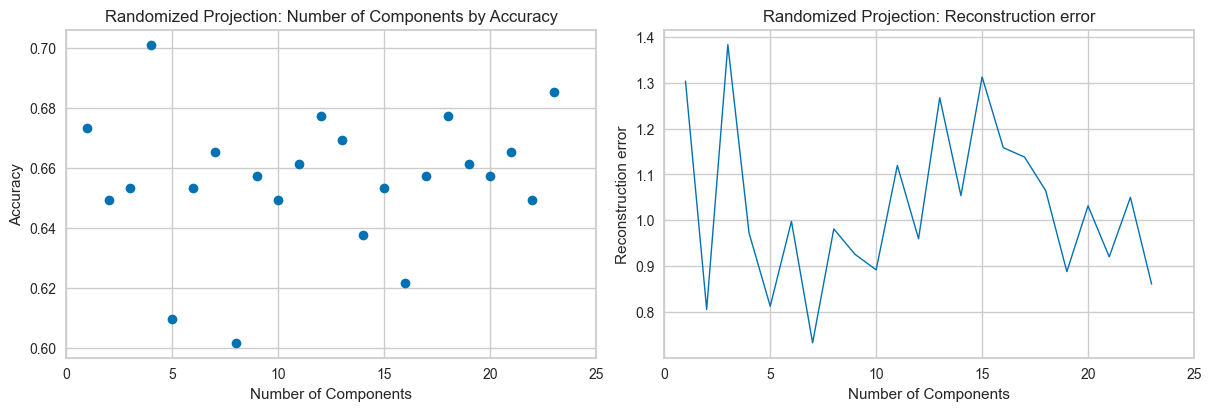

In [32]:
fig, axs = plt.subplots(1 , 2,figsize=(12, 4), constrained_layout=True,)
axs[0].plot(range(1,24),accs,'o')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Components')
axs[0].set_xlim(0,25)
axs[0].set_title('Randomized Projection: Number of Components by Accuracy')

axs[1].plot(range(1,24),reconstruction_error, linewidth= 1)
axs[1].set_ylabel('Reconstruction error')
axs[1].set_xlabel('Number of Components')
axs[1].set_xlim(0,25)
axs[1].set_title('Randomized Projection: Reconstruction error')

## TruncatedSVD

In [33]:


truncatedSVD_losses=[]
truncatedSVD_accs = []

def inverse_transform_truncatedSVD(truncatedSVD, X_transformed, X_train):
	return X_transformed.dot(truncatedSVD.components_) + np.mean(X_train, axis = 0)

for i in range(1,24):
    transformer = TruncatedSVD(n_components=i, random_state=42)
    X_transformed = transformer.fit_transform(x)
    acc=fit_random_forest_classifier(X_transformed, y)
    truncatedSVD_accs.append(acc)
    X_projected = inverse_transform_truncatedSVD(transformer, X_transformed, x)
    reconstructed = ((x - X_projected) ** 2).mean()
    truncatedSVD_losses.append(reconstructed)
    # error = metrics.mean_squared_error(x, reconstructed)
    # fa_losses.append(error)

Text(0.5, 1.0, 'TruncatedSVD: Reconstruction error')

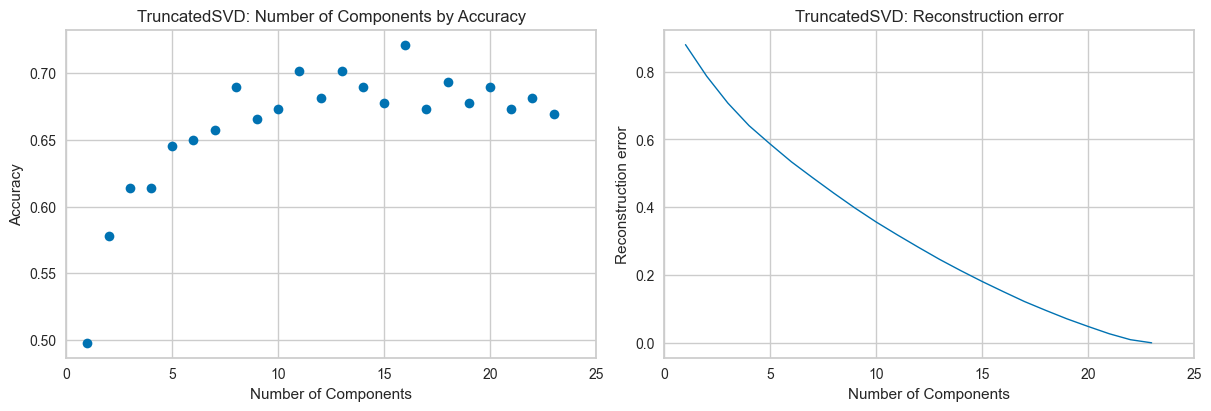

In [34]:
fig, axs = plt.subplots(1 , 2,figsize=(12, 4), constrained_layout=True,)
axs[0].plot(range(1,24),truncatedSVD_accs,'o')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Components')
axs[0].set_xlim(0,25)
axs[0].set_title ('TruncatedSVD: Number of Components by Accuracy')

axs[1].plot(range(1,24),truncatedSVD_losses, linewidth= 1)
axs[1].set_ylabel('Reconstruction error')
axs[1].set_xlabel('Number of Components')
axs[1].set_xlim(0,25)
axs[1].set_title('TruncatedSVD: Reconstruction error')

# Experiment

=======[PCA]========
[PCA]  k-Means -------------
[PCA]  k-Means : #component = 2 ---
[PCA@2] Average Log likelihood for k-Means: 	 -3747.6190681401195
[PCA@2] Adj. Rand Idx for k-Means: 		 0.0446723146198046
[PCA@2] Rand Index for k-Means: 		 0.5223221457001599
[PCA]  k-Means : #component = 3 ---
[PCA@3] Average Log likelihood for k-Means: 	 -6024.556606491585
[PCA@3] Adj. Rand Idx for k-Means: 		 0.044673218056967424
[PCA@3] Rand Index for k-Means: 		 0.5223221457001599
[PCA]  k-Means : #component = 4 ---
[PCA@4] Average Log likelihood for k-Means: 	 -7937.202743414089
[PCA@4] Adj. Rand Idx for k-Means: 		 0.04535174988044425
[PCA@4] Rand Index for k-Means: 		 0.5226638177001395
[PCA]  k-Means : #component = 5 ---
[PCA@5] Average Log likelihood for k-Means: 	 -9501.34278653037
[PCA@5] Adj. Rand Idx for k-Means: 		 0.04535258944779975
[PCA@5] Rand Index for k-Means: 		 0.5226638177001395
[PCA]  k-Means : #component = 6 ---
[PCA@6] Average Log likelihood for k-Means: 	 -11009.941327911

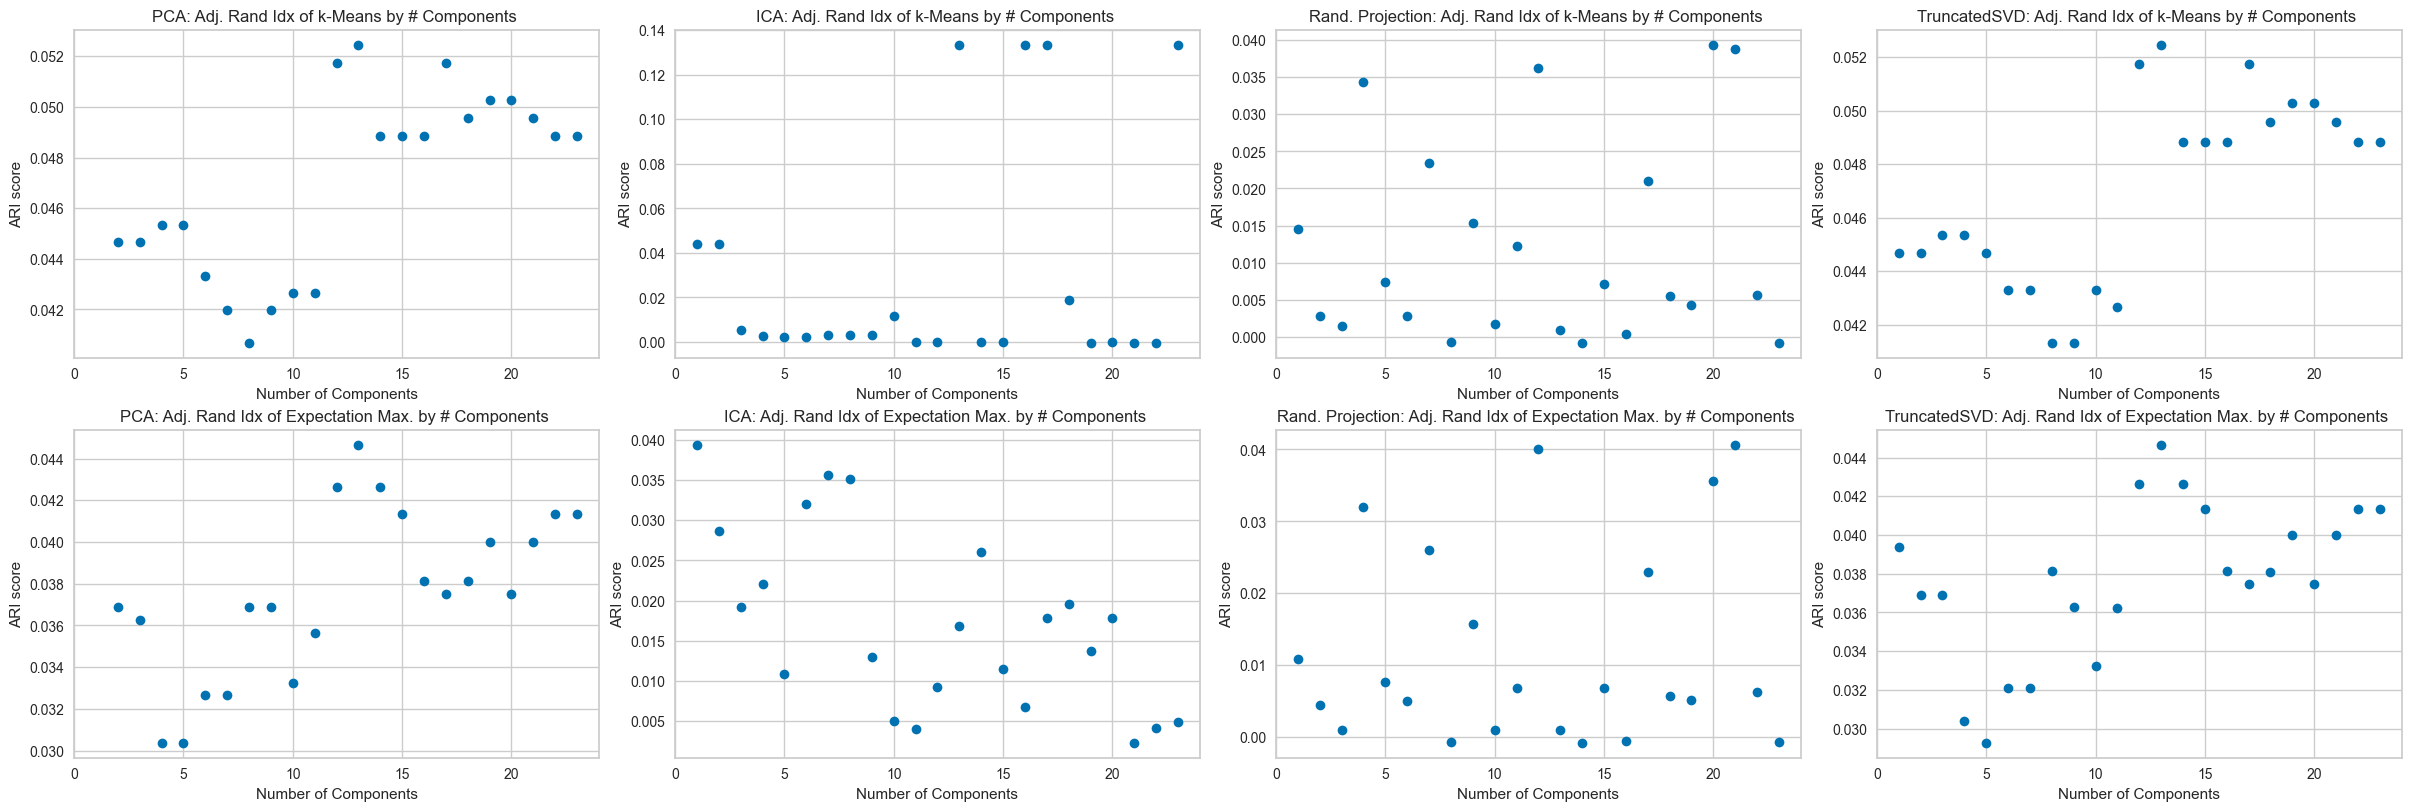

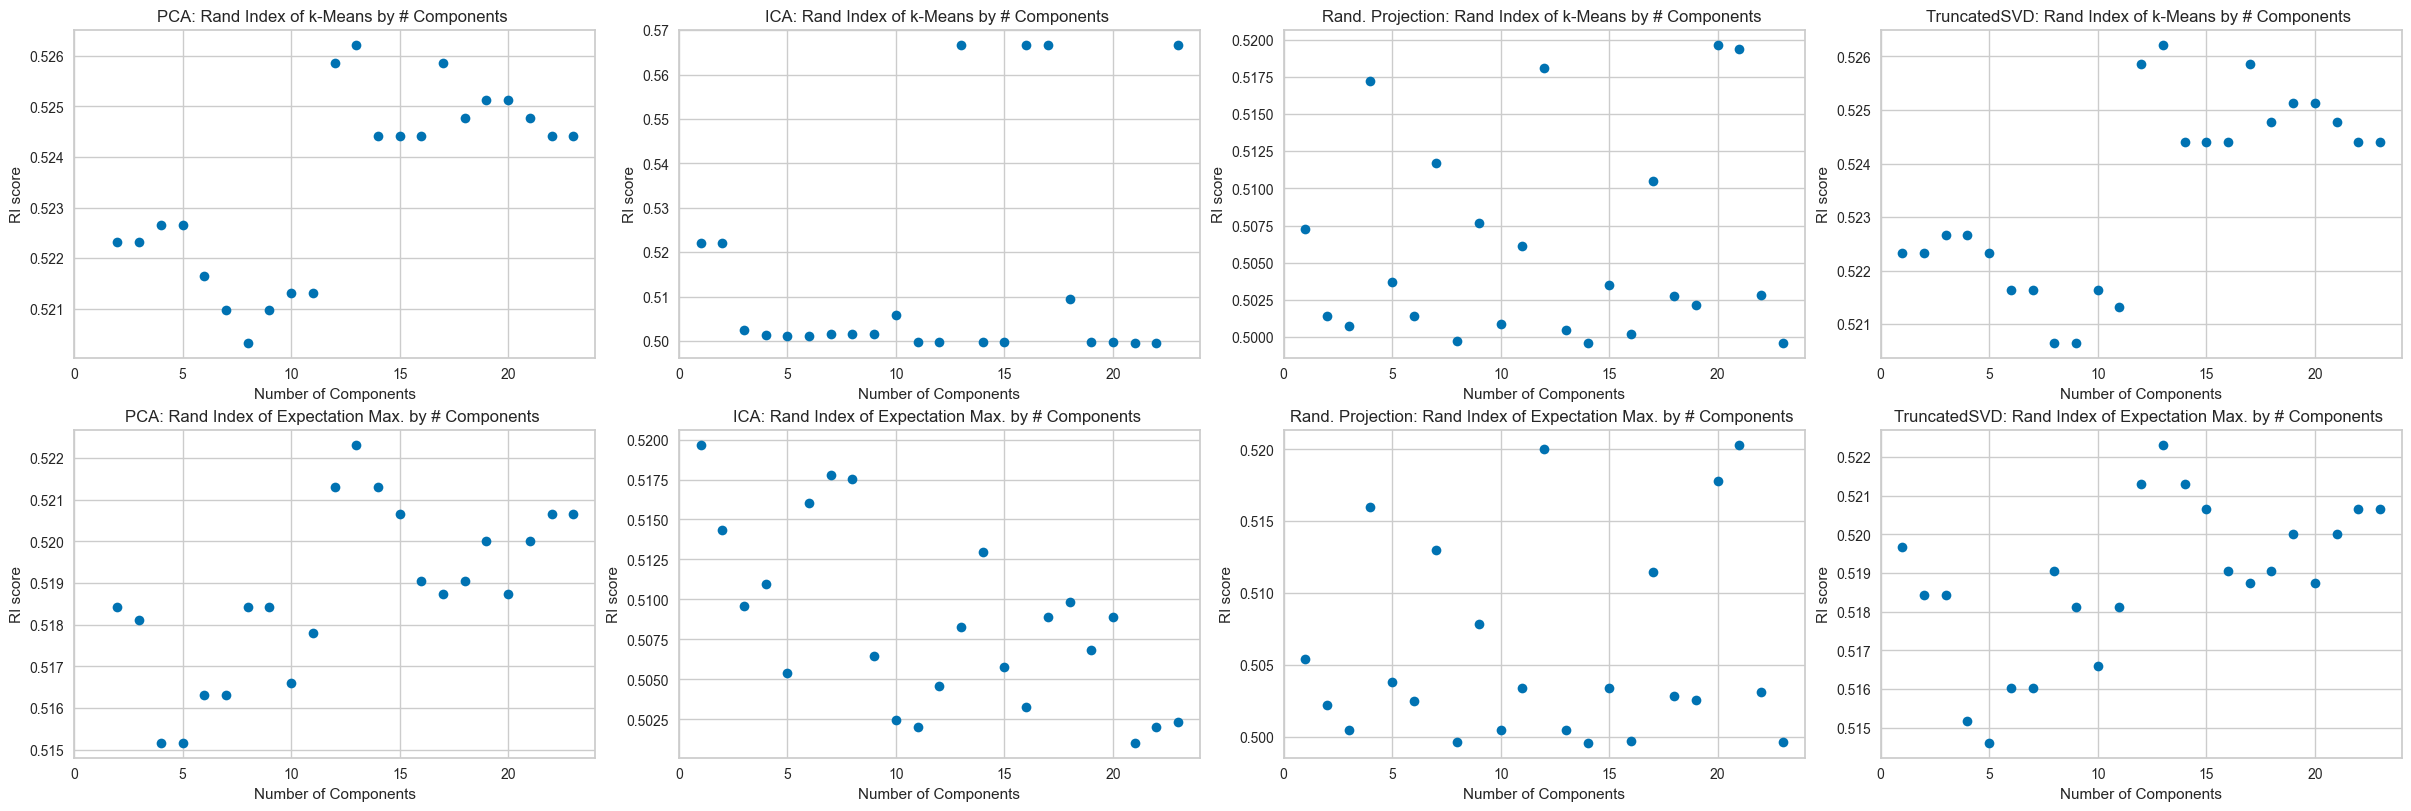

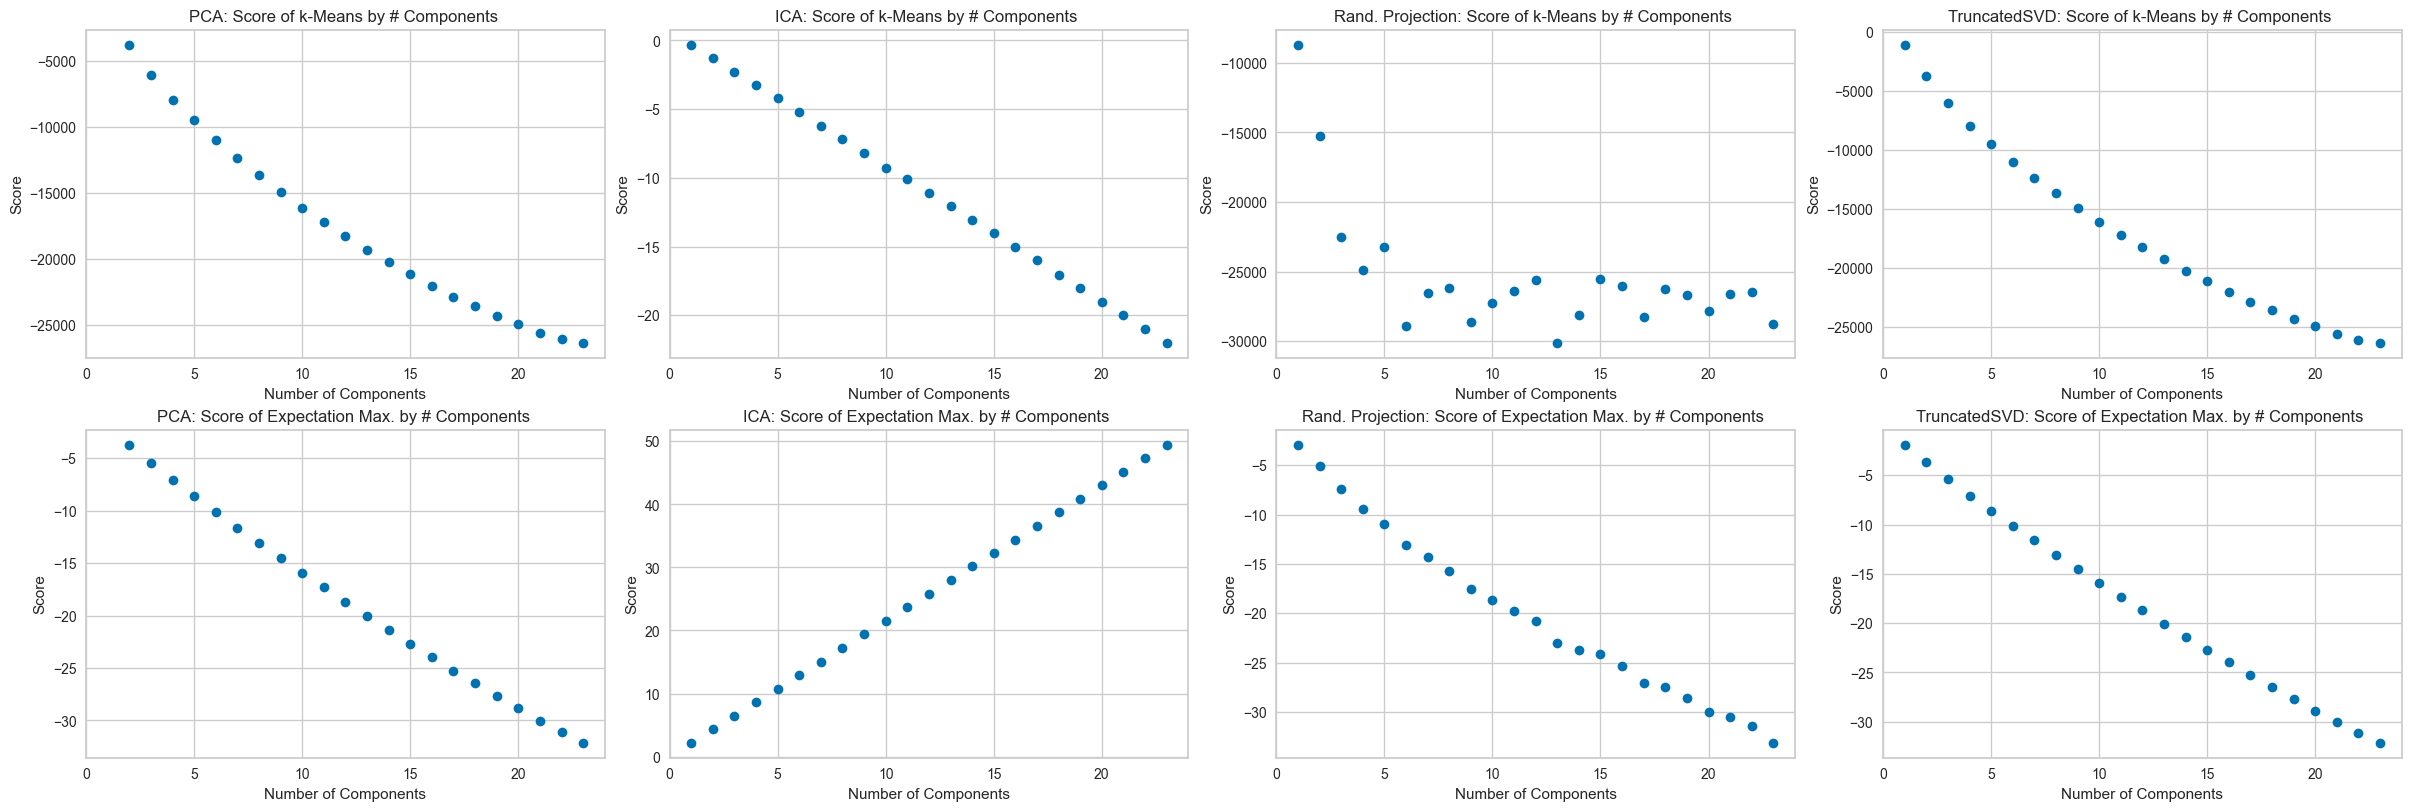

In [39]:
%%time
import pickle
from sklearn.decomposition import PCA

num_class = 2
num_feat = 23
xlim = 24
no_iter = 1000
cl = ['k-Means', 'Expectation Max.']
dr = ['PCA', 'ICA', 'Rand. Projection', 'TruncatedSVD']

fig, axs = plt.subplots(2 , 4,figsize=(24, 8), constrained_layout=True,)
fig1, axs1 = plt.subplots(2 , 4,figsize=(24, 8), constrained_layout=True,)
fig2, axs2 = plt.subplots(2 , 4,figsize=(24, 8), constrained_layout=True,)
ari_score = {}
ri_score = {}
X_transformed = {}
comps = {}
clfs = {}
scores = {}
for i, d in enumerate(dr):
    print(f"=======[{d}]========")
    ari_score[d] = {}
    ri_score[d] = {}
    comps[d] = range(1,num_feat+1) if d != 'PCA' else range(2,num_feat+1)
    X_transformed[d] = {}
    scores[d] = {}
    clfs[d] = {}
    for comp in comps[d]:
        if i == 0:
            transformer = PCA(n_components=comp, random_state=42)
        elif i == 1:
            transformer = FastICA(n_components=comp, random_state=42)
        elif i ==2 :
            transformer = SparseRandomProjection(n_components=comp, random_state=42)
        else:
            transformer = TruncatedSVD(n_components=comp, random_state=42)
        
        X_transformed[d][comp] = transformer.fit_transform(x)

    for j, c in enumerate(cl):
        print(f"[{d}]  {c} -------------")
        ari_score[d][c] = []
        ri_score[d][c] = []
        scores[d][c] = []
        for comp in comps[d]:
            print(f"[{d}]  {c} : #component = {comp} ---")
            if j == 0:
                clf = KMeans(n_clusters=num_class, random_state=42)
            else:
                clf = GaussianMixture(n_components=num_class,covariance_type='spherical', max_iter=no_iter, init_params= 'kmeans', random_state=42)
            clf.fit(X_transformed[d][comp])
            y_pred = clf.predict(X_transformed[d][comp])
            avg_log = clf.score(X_transformed[d][comp])
            scores[d][c].append(avg_log)
            ari = metrics.adjusted_rand_score(y, y_pred)
            ari_score[d][c].append(ari)
            ri = metrics.rand_score(y, y_pred)
            ri_score[d][c].append(ri)
            print(f"[{d}@{comp}] Average Log likelihood for {c}: \t", avg_log)
            print(f"[{d}@{comp}] Adj. Rand Idx for {c}: \t\t", ari)
            print(f"[{d}@{comp}] Rand Index for {c}: \t\t", ri)

        axs[j][i].plot(comps[d],ari_score[d][c],'o')
        axs[j][i].set_ylabel('ARI score')
        axs[j][i].set_xlabel('Number of Components')
        axs[j][i].set_xlim(0,xlim)
        axs[j][i].set_title(f'{d}: Adj. Rand Idx of {c} by # Components ')

        axs1[j][i].plot(comps[d],ri_score[d][c],'o')
        axs1[j][i].set_ylabel('RI score')
        axs1[j][i].set_xlabel('Number of Components')
        axs1[j][i].set_xlim(0,xlim)
        axs1[j][i].set_title(f'{d}: Rand Index of {c} by # Components ')

        axs2[j][i].plot(comps[d],scores[d][c],'o')
        axs2[j][i].set_ylabel('Score')
        axs2[j][i].set_xlabel('Number of Components')
        axs2[j][i].set_xlim(0,xlim)
        axs2[j][i].set_title(f'{d}: Score of {c} by # Components ')
        